[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-smallest-sets.ipynb)

In [1]:
import os #导入 os 模块，用于与操作系统进行交互，例如文件和目录操作
import json #导入 json 模块，用于处理 JSON 数据
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread #导入 matplotlib.image 模块中的 imread 函数，用于读取图像文件
!pip install -U --no-cache-dir gdown --pre #使用 pip 命令安装或升级 gdown 包，并且不使用缓存。--pre 选项表示安装预发布版本。用于从 Google Drive （谷歌云存储）下载文件
#这里!pip install，这是在 Jupyter Notebook 中常用的方式，用于在笔记本单元格中运行 shell 命令

ERROR: Invalid requirement: '#使用': Expected package name at the start of dependency specifier
    #使用
    ^


In [2]:
# Load cached data，调用下载的数据
#检查数据目录是否存在
if not os.path.exists('../data'): #如果../data目录不存在
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz') #使用gdown从Google Drive下载数据文件到../data.tar.gz
    os.system('tar -xf ../data.tar.gz -C ../') #解压缩../data.tar.gz文件到../目录
    os.system('rm ../data.tar.gz') #删除../data.tar.gz文件
if not os.path.exists('../data/imagenet/human_readable_labels.json'): #如果../data/imagenet/human_readable_labels.json文件不存在
    !wget -nv -O ../data/imagenet/human_readable_labels.json -L https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json #使用wget命令从指定url下载json文件并保存到指定目录

data = np.load('../data/imagenet/imagenet-resnet152.npz') #加载../data/imagenet/imagenet-resnet152.npz文件中的数据
example_paths = os.listdir('../data/imagenet/examples') #列出示例路径，即../data/imagenet/examples目录下的所有文件和目录
smx = data['smx'] #获取data中的smx数据，形状为(50000, 1000)，表示50000个样本，每个样本有1000个类别的概率，是50000个样本的softmax函数的输出
labels = data['labels'].astype(int) #获取data中的labels数据，并转换为整数类型，形状为(50000,)，表示50000个样本的真实标签

In [9]:
# 问题建立
n=1000 # 校准数据的样本数量
alpha = 0.1 # 1-alpha是期望覆盖率

In [10]:
#将softmax分数划分为校准集和验证集（保留原始顺序，不进行洗牌）

#创建索引数组，n是校准集数量，smx.shape[0]是总样本数量，这里形成了一个长度为smx.shape[0]=50000的数组，前n=1000个元素为1，后面的元素为0。然后转换为布尔数组，1转换为True，0转换为False
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0 #生成一个数组idx，长度为smx.shape[0]=50000，前n=1000个元素为True，后面的元素为False
np.random.shuffle(idx) #将idx数组洗牌
#分割softmax数据和标签
cal_smx, val_smx = smx[idx,:], smx[~idx,:] #cal_smx选择idx为True的行(形状为1000,1000)，代表校准集的softmax数据；val_smx选择idx为False的行(形状为49000,1000)，代表验证集的softmax数据
cal_labels, val_labels = labels[idx], labels[~idx] #cal_labels选择idx为True的元素(形状为1000,)，代表校准集的真实标签；val_labels选择idx为False的元素(形状为49000,)，代表验证集的真实标签

### Conformal prediction happens here

In [17]:
# 1: 计算保型分数，这里n = calib_Y.shape[0]，即校准数据集的样本数
cal_scores = 1-cal_smx[np.arange(n),cal_labels] #计算保型分数，即1-softmax输出的真实标签对应的概率。这里是提取每个样本对应的真实标签的概率，然后计算1-概率值，共n=1000个样本
# 2: 获取调整后的分位数
q_level = np.ceil((n+1)*(1-alpha))/n #计算调整后的分位数水平q_level，这里alpha时显著性水平（如0.1表示90%置信），np.ceil时将输入的数值向上取整到最近的整数
qhat = np.quantile(cal_scores, q_level, method= 'higher') #计算保型分数（给定数据）的q_level分位数qhat。np.quantile用于根据指定的分位数水平返回数据中的相应值（对数据进行排序后，在特定比例处的值），cal_scores是一维数组（保型分数），q_level是分位数水平，method='higher'表示是计算分位数的方法，higher方法确保返回的分位数是大于或等于指定分位数水平的最小值

# 3: 形成预测集，对于每个样本，如果模型对某个类别的预测概率大于等于1-qhat，则该类别包含在预测集中
prediction_sets = val_smx >= (1-qhat)  #输出形状为(49000,1000)，每个元素为True或False，代表验证集的每个样本的每个类别的概率是否大于等于1-qhat

In [27]:
# 计算经验覆盖率（empirical coverage）
#具体做法是提取每个样本对应的真实标签的softmax预测概率是否大于等于1-qhat，如果是True在计算平均值是记为1，否则记为0，最后计算平均值
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.9066326530612245


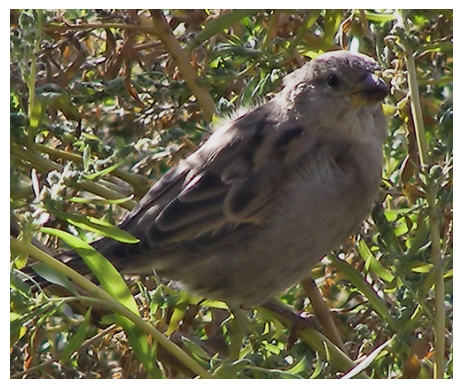

The prediction set is: ['brambling', 'house finch', 'junco']


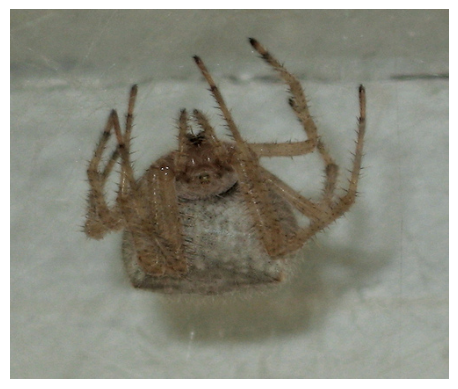

The prediction set is: ['barn spider', 'wolf spider']


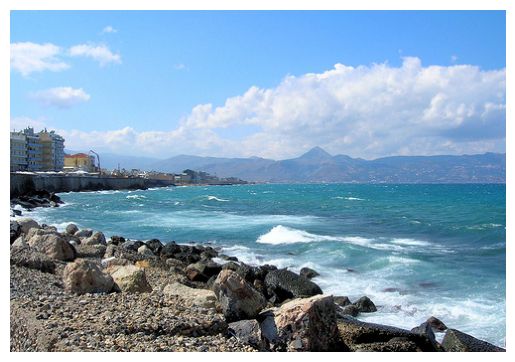

The prediction set is: ['breakwater', 'promontory', 'seashore']


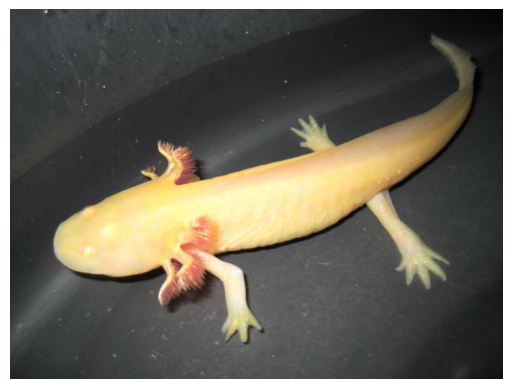

The prediction set is: ['axolotl']


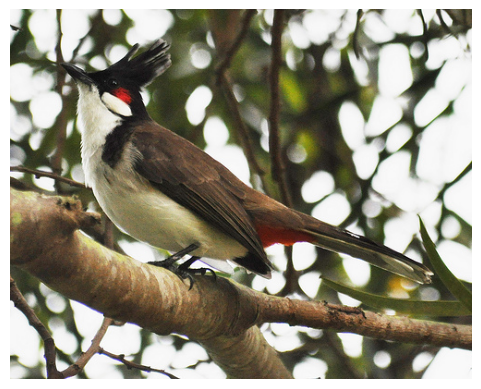

The prediction set is: ['bulbul']


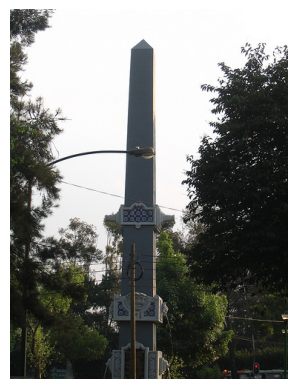

The prediction set is: ['obelisk']


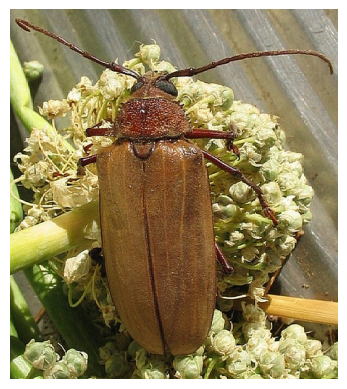

The prediction set is: ['longhorn beetle']


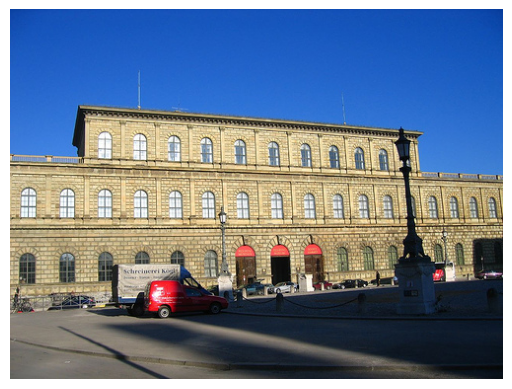

The prediction set is: ['golf cart', 'palace']


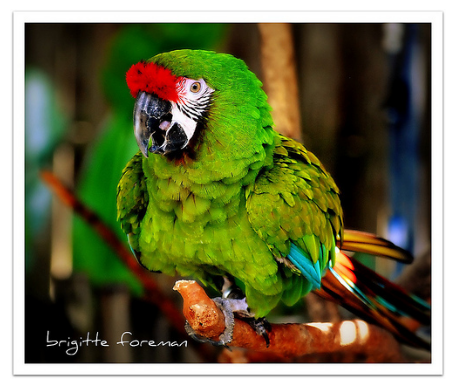

The prediction set is: ['macaw']


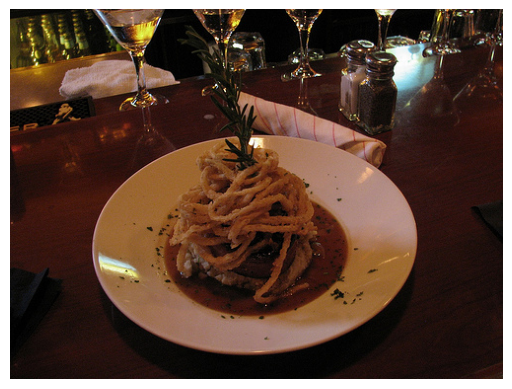

The prediction set is: ['plate', 'mashed potato', 'carbonara']


In [28]:
#随机选取 10 张示例图片，并展示其保型预测集

#加载imagenet标签。这里打开并读取json文件，包含1000个类别的标签，存储在label_strings中
with open('../data/imagenet/human_readable_labels.json') as f:
    label_strings = np.array(json.load(f))

example_paths =os.listdir('../data/imagenet/examples') #获取示例图片的路径
for i in range(10): #逐个展示10张图片及其预测集
    rand_path = np.random.choice(example_paths) #随机选择一张图片
    img = imread('../data/imagenet/examples/' + rand_path ) #读取并显示图片
    img_index = int(rand_path.split('.')[0]) #获取图像索引。这里是提取文件名的数字部分（假设文件名是"42.JPEG"，提取"42"）
    prediction_set = smx[img_index] > 1-qhat #获取预测集。这里是提取smx中的第img_index行（就是softmax输出），然后判断每个类的softmax概率是否大于1-qhat
    #显示图片
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #输出预测集，即softmax概率大于1-qhat的类别
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

### This method leads to small sets, but sacrifices adaptivity. [Click this link](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-raps.ipynb) for an improvement.

This method was studied in https://arxiv.org/abs/1609.00451.